In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
%run 01_LLMs_konfigurieren.ipynb

In [3]:
%run 02_Daten_laden.ipynb

In [4]:
irony_subset = irony_final[:1001]
irony_subset

,index,Label,text
0,0,1,Sweet United Nations video. Just in time for C...
1,1,1,@mrdahl87 We are rumored to have talked to Erv...
2,2,1,Hey there! Nice to see you Minnesota/ND Winter...
3,3,0,3 episodes left I'm dying over here
4,4,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
996,996,0,It was a greaaaat night! :white_smiling_face:️...
997,997,0,@StephHammy I wonder if they have that in an a...
998,998,0,Queens Of The Stone Age no Rock In Rio http://...
999,999,1,@jordyn_eaton wants me to get hit by a bus so ...


# Chain of thought

## OpenAI / GPT

In [5]:
openai_client

### Cot

In [5]:
from pydantic import BaseModel

class Step(BaseModel):
    explanation: str
    output: str

class CoT(BaseModel):
    steps: list[Step]
    final_answer: str

In [6]:
# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gpt_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in irony_subset.iterrows():
    text = row['text']
    #print(text)

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = openai_client.beta.chat.completions.parse( # .chat.completions.create(
            model="gpt-4o", # gpt-3.5-turbo # gpt-4o-mini
            messages=[
                { # Return only 0 or 1 without additional text. Use 0 for negative and 1 for positive Sentiments.
                "role": "system", 
                "content": """You determine whether a text contains ironic or sarcastic elements.
                            Analyze the text carefully and explain your reasoning step-by-step before providing the final answer.
                    Return 0 for No and 1 for Yes."""
                },
                {
                "role": "user",
                 "content": (f"""
                    Does the following text contains ironic or sarcastic elements?
                    
                    Text: {text}.""")
                }
            ],
            temperature = 0.2,
            response_format=CoT
        )
        response_content = response.choices[0].message.parsed #response.choices[0].message.content
        result_step = response_content.steps
        final_answer = response_content.final_answer
        print(index, response_content)
        # print(index, " ", "Label: ",final_answer )        
        

        # Ergebnis in das DataFrame effizient speichern
        results_gpt_df.loc[row_counter] = [index, text, result_step, final_answer] # [index, text, steps, response_content]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")





0 steps=[Step(explanation="The text begins with 'Sweet United Nations video,' which seems to be a positive statement about the video. However, the use of 'Sweet' in this context could be interpreted as sarcastic, depending on the speaker's tone or intention, which is not clear from the text alone.", output='Uncertain'), Step(explanation="The phrase 'Just in time for Christmas' could be interpreted in multiple ways. It could be a genuine remark about the timing of the video's release, or it could be sarcastic, suggesting that the video is not actually appropriate or relevant for Christmas.", output='Uncertain'), Step(explanation="The hashtags '#imagine' and '#NoReligion' suggest themes related to John Lennon's song 'Imagine,' which envisions a world without religion. The use of these hashtags could be sincere, promoting the video's message, or sarcastic, mocking the video's content or timing.", output='Uncertain'), Step(explanation="The inclusion of a link to the video suggests that the

In [7]:
results_gpt_df

,index,sentence,steps,generated_label
0,0,Sweet United Nations video. Just in time for C...,"[explanation=""The text begins with 'Sweet Unit...",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"[explanation=""The text mentions rumors about t...",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,"[explanation=""The text begins with a greeting,...",1
3,3,3 episodes left I'm dying over here,"[explanation='The phrase ""I\'m dying over here...",0
4,4,I can't breathe! was chosen as the most notabl...,"[explanation='The phrase ""I can\'t breathe!"" i...",0
...,...,...,...,...
996,996,It was a greaaaat night! :white_smiling_face:️...,"[explanation=""The text uses the word 'greaaaat...",1
997,997,@StephHammy I wonder if they have that in an a...,"[explanation=""The text is a tweet directed at ...",0
998,998,Queens Of The Stone Age no Rock In Rio http://...,[explanation='The text is a simple statement a...,0
999,999,@jordyn_eaton wants me to get hit by a bus so ...,[explanation='The text mentions that someone w...,1


In [8]:
sicherung = results_gpt_df

In [9]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gpt_df['generated_label'] = results_gpt_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gpt_df_final = results_gpt_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gpt_df_final['generated_label'] = results_gpt_df_final['generated_label'].replace({'no': 0, 'yes': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gpt_df_final_ver = results_gpt_df_final[results_gpt_df_final['generated_label'].isin(['0', '1',0, 1])]

# als int formatieren
results_gpt_df_final_ver['generated_label'] = results_gpt_df_final_ver['generated_label'].astype(int)




In [10]:
results_gpt_df_final_ver

,index,sentence,steps,generated_label
0,0,Sweet United Nations video. Just in time for C...,"[explanation=""The text begins with 'Sweet Unit...",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,"[explanation=""The text mentions rumors about t...",1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,"[explanation=""The text begins with a greeting,...",1
3,3,3 episodes left I'm dying over here,"[explanation='The phrase ""I\'m dying over here...",0
4,4,I can't breathe! was chosen as the most notabl...,"[explanation='The phrase ""I can\'t breathe!"" i...",0
...,...,...,...,...
996,996,It was a greaaaat night! :white_smiling_face:️...,"[explanation=""The text uses the word 'greaaaat...",1
997,997,@StephHammy I wonder if they have that in an a...,"[explanation=""The text is a tweet directed at ...",0
998,998,Queens Of The Stone Age no Rock In Rio http://...,[explanation='The text is a simple statement a...,0
999,999,@jordyn_eaton wants me to get hit by a bus so ...,[explanation='The text mentions that someone w...,1


In [11]:

# CSV abspeichern 
results_gpt_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/MAST_ZeroShot_CoT_GPT4o.csv', encoding='utf-8-sig')


### Evaluation

In [12]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(irony_subset, results_gpt_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['Label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.66
Precision: 0.61
Recall: 0.91
F1-Score: 0.73
Confusion Matrix:
[[197 293]
 [ 48 463]]


In [13]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.80      0.40      0.54       490
           1       0.61      0.91      0.73       511

    accuracy                           0.66      1001
   macro avg       0.71      0.65      0.63      1001
weighted avg       0.71      0.66      0.64      1001



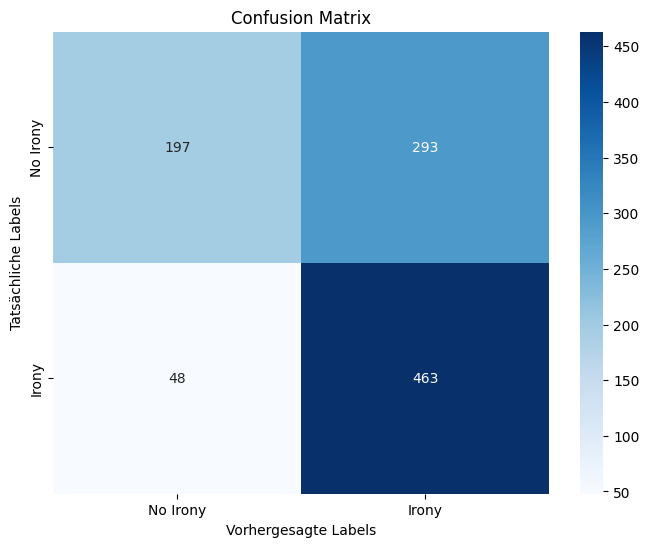

In [14]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['No Irony', 'Irony']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()

## Gemini

In [14]:
genai_model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash',
    generation_config={'temperature': 0.2},
    safety_settings={<HarmCategory.HARM_CATEGORY_HARASSMENT: 7>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_HATE_SPEECH: 8>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: 9>: <HarmBlockThreshold.BLOCK_NONE: 4>, <HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: 10>: <HarmBlockThreshold.BLOCK_NONE: 4>},
    tools=None,
    system_instruction=None,
    cached_content=None
)

### Irony

In [12]:
irony_subset = irony_final[:1001]
irony_subset

,index,Label,text
0,0,1,Sweet United Nations video. Just in time for C...
1,1,1,@mrdahl87 We are rumored to have talked to Erv...
2,2,1,Hey there! Nice to see you Minnesota/ND Winter...
3,3,0,3 episodes left I'm dying over here
4,4,1,I can't breathe! was chosen as the most notabl...
...,...,...,...
996,996,0,It was a greaaaat night! :white_smiling_face:️...
997,997,0,@StephHammy I wonder if they have that in an a...
998,998,0,Queens Of The Stone Age no Rock In Rio http://...
999,999,1,@jordyn_eaton wants me to get hit by a bus so ...


In [16]:
# System-Prompts

genai_model=genai.GenerativeModel(
  model_name="gemini-1.5-flash",
    safety_settings='BLOCK_NONE',
    system_instruction="""You determine whether a text contains ironic or sarcastic elements. 
                            Return 0 for No and 1 for Yes. Use this JSON Schema: Result = {'steps':str, 'final_answer': str} 
                 """,
    generation_config={"response_mime_type": "application/json"})





# Leeres DataFrame erstellen, um die Ergebnisse zu speichern
results_gemini_df = pd.DataFrame(columns=['index', 'sentence','steps', 'generated_label'])

# Zähler für das Einfügen in das DataFrame
row_counter = 0

# Schleife mit API-Call
for index, row in irony_subset.iterrows():
    text = row['text']

    try:
        # GenAI Model-Aufruf für die Sentiment-Klassifikation
        response = genai_model.generate_content(f"""
                    Does the following text contains ironic or sarcastic elements?
                    Analyze the text carefully and explain your reasoning step-by-step before providing the final answer. 
                    Return ONLY 0 or 1 for the final_answer!
                 Text: {text}.""")
        llm_output = response.text
        # print(llm_output)
        
        # dict speichern
        resp_dict = json.loads(llm_output)

        # durch dict iterieren
        steps = resp_dict['steps']
        final_result = resp_dict['final_answer']
        
        print(index, " ", "output:  ", final_result)

        # Ergebnis in das DataFrame effizient speichern
        results_gemini_df.loc[row_counter] = [index, text, steps, final_result]
        row_counter += 1

    except Exception as e:
        # Fehlerbehandlung, wenn etwas beim API-Aufruf oder Speichern schiefgeht
        print(f"Fehler bei der Verarbeitung der Zeile {index}: {str(e)}")



0   output:   1
1   output:   1
2   output:   1
3   output:   1
4   output:   1
5   output:   1
6   output:   1
7   output:   1
8   output:   1
9   output:   1
10   output:   1
11   output:   1
12   output:   1
13   output:   1
14   output:   1
15   output:   1
16   output:   1
17   output:   1
18   output:   1
19   output:   1
20   output:   1
21   output:   1
22   output:   1
23   output:   1
24   output:   1
25   output:   1
26   output:   1
27   output:   1
28   output:   1
29   output:   1
30   output:   1
31   output:   1
32   output:   1
33   output:   1
34   output:   1
35   output:   0
36   output:   1
37   output:   1
38   output:   1
39   output:   1
40   output:   1
41   output:   1
42   output:   1
43   output:   1
44   output:   1
45   output:   0
46   output:   1
47   output:   0
48   output:   1
49   output:   1
50   output:   1
51   output:   1
52   output:   1
53   output:   1
54   output:   1
55   output:   1
56   output:   1
57   output:   1
58   output:   1
59   ou

In [18]:
results_gemini_df

,index,sentence,steps,generated_label
0,0,Sweet United Nations video. Just in time for C...,"The text uses the hashtag ""#NoReligion"" in a t...",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,The text contains a wink emoji ;). The wink em...,1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,The text expresses a sense of sarcasm because ...,1
3,3,3 episodes left I'm dying over here,"The text ""3 episodes left I'm dying over here....",1
4,4,I can't breathe! was chosen as the most notabl...,"The text is ironic because the phrase ""I can't...",1
...,...,...,...,...
994,996,It was a greaaaat night! :white_smiling_face:️...,The text uses emojis that are usually associat...,1
995,997,@StephHammy I wonder if they have that in an a...,"The text is a tweet, so the context is importa...",1
996,998,Queens Of The Stone Age no Rock In Rio http://...,The text mentions Queens Of The Stone Age play...,1
997,999,@jordyn_eaton wants me to get hit by a bus so ...,The text uses sarcasm because the user is impl...,1


In [19]:
# Datenaufbereitung 

# Entferne Zeilenumbrüche und Leerzeichen aus der Spalte 'generated_label'
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.strip()

# Wandelt die Werte in Kleinbuchstaben um
results_gemini_df['generated_label'] = results_gemini_df['generated_label'].str.lower()

# Mapping: 'negative' zu 0, 'positive' zu 1
results_gemini_df_final = results_gemini_df # [results_gpt_df['generated_label'].isin(['0', '1',0,1])]

results_gemini_df_final['generated_label'] = results_gemini_df_final['generated_label'].replace({'no': 0, 'yes': 1})

# Filtert den DataFrame, um nur Zeilen zu behalten, bei denen der Wert in 'generated_label' 0 oder 1 ist
results_gemini_df_final_ver = results_gemini_df_final[results_gemini_df_final['generated_label'].isin([0, 1,'0','1'])]

# als int formatieren
results_gemini_df_final_ver['generated_label'] = results_gemini_df_final_ver['generated_label'].astype(int)




In [20]:
results_gemini_df_final_ver

,index,sentence,steps,generated_label
0,0,Sweet United Nations video. Just in time for C...,"The text uses the hashtag ""#NoReligion"" in a t...",1
1,1,@mrdahl87 We are rumored to have talked to Erv...,The text contains a wink emoji ;). The wink em...,1
2,2,Hey there! Nice to see you Minnesota/ND Winter...,The text expresses a sense of sarcasm because ...,1
3,3,3 episodes left I'm dying over here,"The text ""3 episodes left I'm dying over here....",1
4,4,I can't breathe! was chosen as the most notabl...,"The text is ironic because the phrase ""I can't...",1
...,...,...,...,...
994,996,It was a greaaaat night! :white_smiling_face:️...,The text uses emojis that are usually associat...,1
995,997,@StephHammy I wonder if they have that in an a...,"The text is a tweet, so the context is importa...",1
996,998,Queens Of The Stone Age no Rock In Rio http://...,The text mentions Queens Of The Stone Age play...,1
997,999,@jordyn_eaton wants me to get hit by a bus so ...,The text uses sarcasm because the user is impl...,1


In [21]:

# CSV abspeichern 
results_gemini_df_final_ver.to_csv('/Users/marvinschmitt/Library/CloudStorage/OneDrive-Persönlich/M.Sc. Data Science/17 Masterarbeit/Repo/Prod/CSVs/MAST_ZeroShot_CoT_GEMINI.csv', encoding='utf-8-sig')


#### Evaluation

In [22]:

# Annahme: Beide DataFrames haben eine Spalte 'index' als gemeinsamen Schlüssel
# results_gpt_df: enthält die von LLM generierten Sentiment-Labels
# sst2_subset: enthält die tatsächlichen (gold standard) Sentiment-Labels

# Beide DataFrames anhand der 'index'-Spalte mergen
df_combined = pd.merge(irony_subset, results_gemini_df_final_ver, on='index')

# Die Spalten 'label' und 'generated_label' sollten die tatsächlichen und vorhergesagten Labels enthalten
true_labels = df_combined['Label']  # Tatsächliche Labels (z.B. aus SST2)
predicted_labels = df_combined['generated_label']  # Vorhergesagte Labels (z.B. aus GPT)

# 1. Accuracy (Genauigkeit)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')

# 2. Precision (Genauigkeit der positiven Klassifikation)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
print(f'Precision: {precision:.2f}')

# 3. Recall (Empfindlichkeit, Trefferquote)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
print(f'Recall: {recall:.2f}')

# 4. F1-Score (harmonisches Mittel von Precision und Recall)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)
print(f'F1-Score: {f1:.2f}')

# 5. Confusion Matrix (Verwirrungsmatrix)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=[0,1])
print('Confusion Matrix:')
print(conf_matrix)

Accuracy: 0.55
Precision: 0.53
Recall: 0.97
F1-Score: 0.69
Confusion Matrix:
[[ 52 437]
 [ 14 496]]


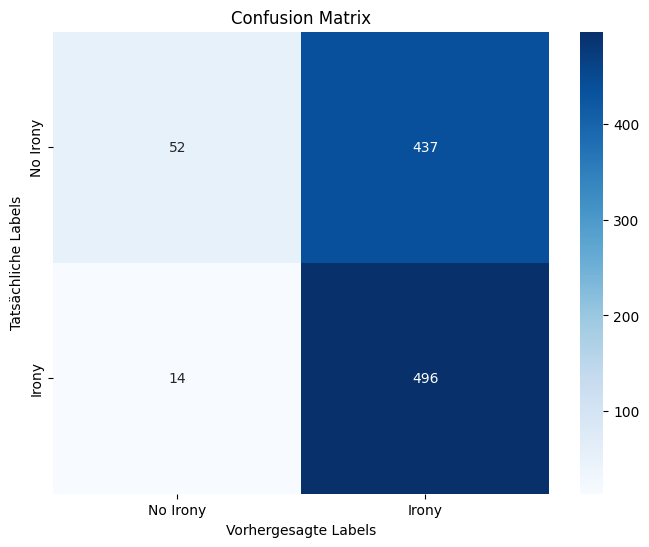

In [23]:
# Confusion Matrix berechnen (true_labels und predicted_labels sind die tatsächlichen und vorhergesagten Labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Klassenlabels definieren
class_names = ['No Irony', 'Irony']

# Confusion Matrix als Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Achsen beschriften
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Tatsächliche Labels')
plt.title('Confusion Matrix')

# Plot anzeigen
plt.show()